In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    classification_report,
)

from src.data_loader import load_diabetes_data
from src.preprocessing import split_features_target
from src.model_selection import compare_models
from src.train_model import train_and_save_model

In [9]:
df = load_diabetes_data()
X, y = split_features_target(df)

In [10]:
X.shape, y.shape

((100000, 30), (100000,))

In [11]:
pos_rate = y.mean()
print(f"Proporción de positivos (diagnosed_diabetes=1): {pos_rate:.3f}")

use_smote = pos_rate < 0.3 or pos_rate > 0.7
print("¿Usar SMOTE?", use_smote)

Proporción de positivos (diagnosed_diabetes=1): 0.600
¿Usar SMOTE? False


In [12]:
cv_results = compare_models(X, y, use_smote=use_smote)
cv_results

{'logistic': ModelCVResult(name='logistic', estimator=Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['age',
                                                    'alcohol_consumption_per_week',
                                                    'physical_activity_minutes_per_week',
                                                    'diet_score',
                                                    'sleep_hours_per_day',
                                                    'screen_time_hours_per_day',
                                                    'family_history_diabetes',
                                                    'hypertension_history',
                                                    'cardiovascular_history',
  

In [13]:
for name, res in cv_results.items():
    print(f"\nModelo: {name}")
    for metric, score in res.cv_scores.items():
        print(f"  {metric}: {score:.3f}")



Modelo: logistic
  roc_auc: 1.000
  bal_acc: 0.999
  recall: 0.999
  precision: 1.000
  f1: 1.000
  pr_auc: 1.000

Modelo: random_forest
  roc_auc: 1.000
  bal_acc: 1.000
  recall: 0.999
  precision: 1.000
  f1: 1.000
  pr_auc: 1.000


In [14]:
metrics = train_and_save_model()
metrics

Mejor modelo según ROC-AUC CV: random_forest (1.000)

=== Clasification report (umbral óptimo) ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      8000
           1      0.600     1.000     0.750     12000

    accuracy                          0.600     20000
   macro avg      0.300     0.500     0.375     20000
weighted avg      0.360     0.600     0.450     20000



C:\Users\lohan\OneDrive\Escritorio\CYGNUS\claro\claro\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lohan\OneDrive\Escritorio\CYGNUS\claro\claro\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lohan\OneDrive\Escritorio\CYGNUS\claro\claro\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _


Modelo guardado en: C:\Users\lohan\DataspellProjects\MachineLearning1\models\modelo_diabetes.joblib
Métricas guardadas en: C:\Users\lohan\DataspellProjects\MachineLearning1\reports\metrics.json


{'best_model_name': 'random_forest',
 'cv_roc_auc': 0.9999988021101112,
 'test_roc_auc': 0.9999986354166667,
 'test_balanced_accuracy_default_thr': 0.9996875000000001,
 'optimal_threshold': 0.00033309812144309,
 'optimal_precision': 0.6,
 'optimal_recall': 1.0,
 'test_balanced_accuracy_opt_thr': 0.5}

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from src.model_selection import _build_logistic_pipeline, _build_rf_pipeline


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [17]:
best_model_name = metrics["best_model_name"]
print("Mejor modelo según CV:", best_model_name)

if best_model_name == "logistic":
    base_pipeline = _build_logistic_pipeline(use_smote=use_smote)
else:
    base_pipeline = _build_rf_pipeline(use_smote=use_smote)

calibrated_clf = CalibratedClassifierCV(
    estimator=base_pipeline,
    cv=3,
    method="sigmoid",
)

calibrated_clf.fit(X_train, y_train)

y_proba_test = calibrated_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_test)
print(f"ROC-AUC en test (re-entrenado aquí): {roc_auc:.3f}")

Mejor modelo según CV: random_forest
ROC-AUC en test (re-entrenado aquí): 1.000


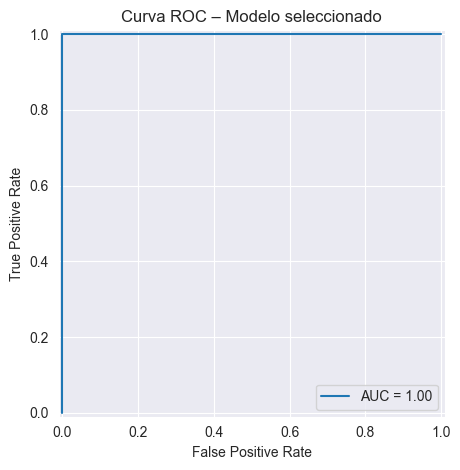

In [18]:
fpr, tpr, thr_roc = roc_curve(y_test, y_proba_test)
fig, ax = plt.subplots()
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_disp.plot(ax=ax)
ax.set_title("Curva ROC – Modelo seleccionado")
plt.tight_layout()

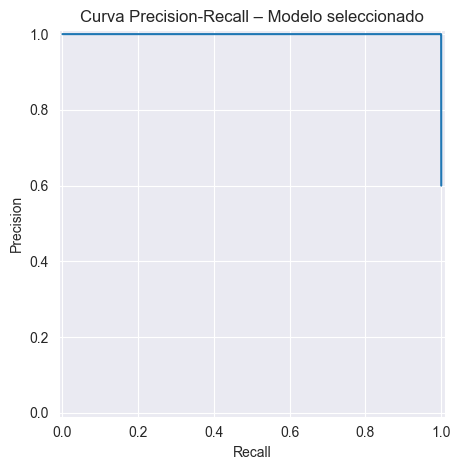

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)

fig, ax = plt.subplots()
pr_disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
pr_disp.plot(ax=ax)
ax.set_title("Curva Precision-Recall – Modelo seleccionado")
plt.tight_layout()

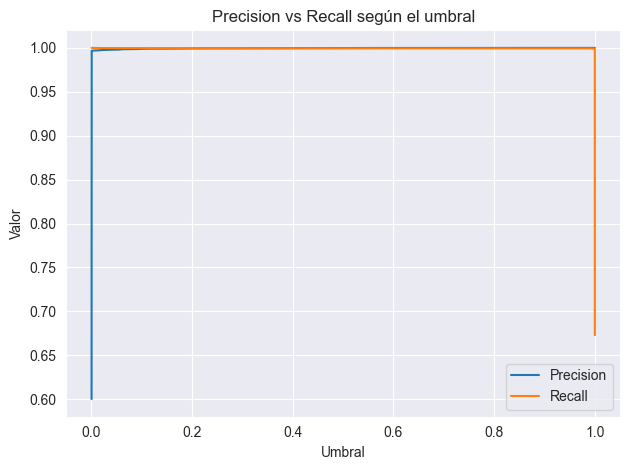

In [20]:
thr_plot = thresholds
prec_plot = precisions[:-1]
rec_plot = recalls[:-1]

fig, ax = plt.subplots()
ax.plot(thr_plot, prec_plot, label="Precision")
ax.plot(thr_plot, rec_plot, label="Recall")
ax.set_xlabel("Umbral")
ax.set_ylabel("Valor")
ax.set_title("Precision vs Recall según el umbral")
ax.legend()
plt.tight_layout()

In [21]:
thr_default = 0.5
thr_opt = metrics["optimal_threshold"]

y_pred_default = (y_proba_test >= thr_default).astype(int)
y_pred_opt = (y_proba_test >= thr_opt).astype(int)

print("=== Reporte clasificación (umbral 0.5) ===")
print(classification_report(y_test, y_pred_default, digits=3))

print("\n=== Reporte clasificación (umbral óptimo) ===")
print(classification_report(y_test, y_pred_opt, digits=3))

bal_default = balanced_accuracy_score(y_test, y_pred_default)
bal_opt = balanced_accuracy_score(y_test, y_pred_opt)
print(f"\nBalanced Accuracy (0.5): {bal_default:.3f}")
print(f"Balanced Accuracy (thr_opt={thr_opt:.3f}): {bal_opt:.3f}")

=== Reporte clasificación (umbral 0.5) ===
              precision    recall  f1-score   support

           0      0.999     1.000     1.000      8000
           1      1.000     1.000     1.000     12000

    accuracy                          1.000     20000
   macro avg      1.000     1.000     1.000     20000
weighted avg      1.000     1.000     1.000     20000


=== Reporte clasificación (umbral óptimo) ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      8000
           1      0.600     1.000     0.750     12000

    accuracy                          0.600     20000
   macro avg      0.300     0.500     0.375     20000
weighted avg      0.360     0.600     0.450     20000


Balanced Accuracy (0.5): 1.000
Balanced Accuracy (thr_opt=0.000): 0.500


C:\Users\lohan\OneDrive\Escritorio\CYGNUS\claro\claro\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lohan\OneDrive\Escritorio\CYGNUS\claro\claro\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lohan\OneDrive\Escritorio\CYGNUS\claro\claro\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _